# Linear regression: health insurance cost

## Notebook setup

Handle imports of necessary modules up-front.

In [38]:
# Standard library imports
from pathlib import Path

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Custom functions for this notebook
import helper_functions as funcs

## 1. Data loading

### 1.1. Load

In [39]:
data_url = 'https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv'
data_df = pd.read_csv(data_url, sep=',')

### 1.2. Save local copy

In [40]:
# Make a directory for raw data
Path('../data/raw').mkdir(exist_ok=True, parents=True)

# Save a local copy of the raw data
data_df.to_parquet('../data/raw/medical-insurance-cost.parquet')

### 1.3. Inspect

In [41]:
data_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [42]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## 2. EDA

### 2.1. Data composition

#### 2.1.1. Interval features

In [43]:
interval_features=['age','bmi','children','charges']
data_df[interval_features].describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


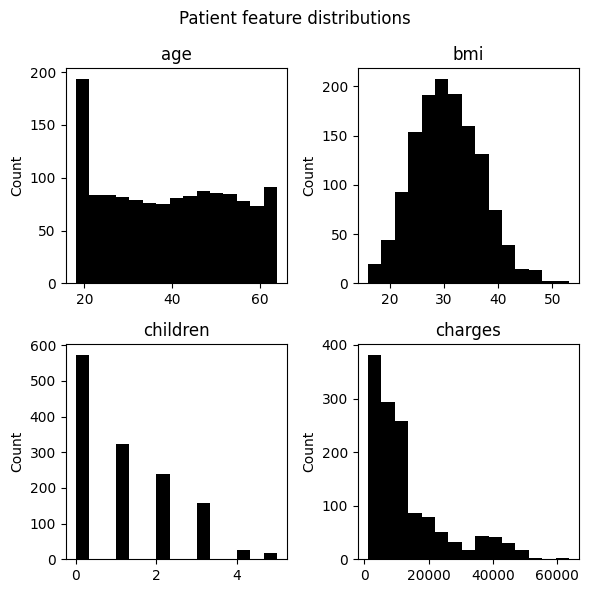

In [44]:
fig, axs = plt.subplots(2,2, figsize=(6,6))
axs = axs.flatten()

fig.suptitle('Patient feature distributions')

for i, feature in enumerate(interval_features):
    axs[i].set_title(feature)
    axs[i].hist(data_df[feature], color='black', bins=15)
    axs[i].set_ylabel('Count')

fig.tight_layout()
fig.show()

#### 2.1.2. Nominal features

In [45]:
nominal_features=['sex','smoker','region']
level_counts = funcs.get_level_counts(data_df, nominal_features)
level_counts.head(len(level_counts))

Count
feature level           
sex     male         676
        female       662
smoker  no          1064
        yes          274
region  southeast    364
        southwest    325
        northwest    325
        northeast    324

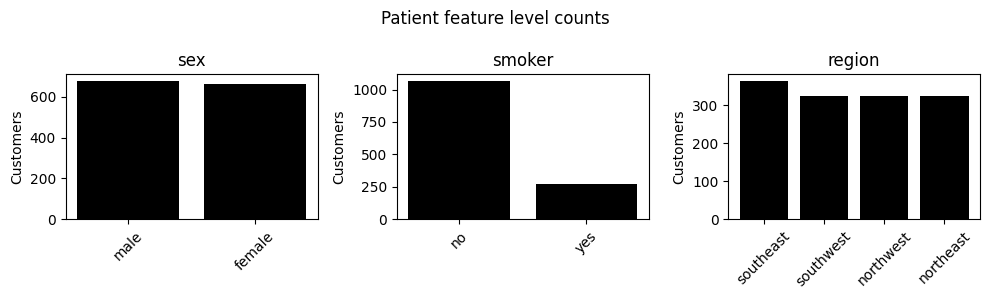

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs = axs.flatten()

fig.suptitle('Patient feature level counts')

for i, feature in enumerate(nominal_features):

    level_counts = data_df[feature].value_counts()

    axs[i].set_title(feature)
    axs[i].bar(list(range(len(level_counts))), level_counts, tick_label=level_counts.index, color='black')
    axs[i].tick_params(axis='x', labelrotation=45)
    axs[i].set_ylabel('Customers')

fig.tight_layout()
fig.show()

### 2.2. Feature interactions

#### 2.2.1. Interval features vs label

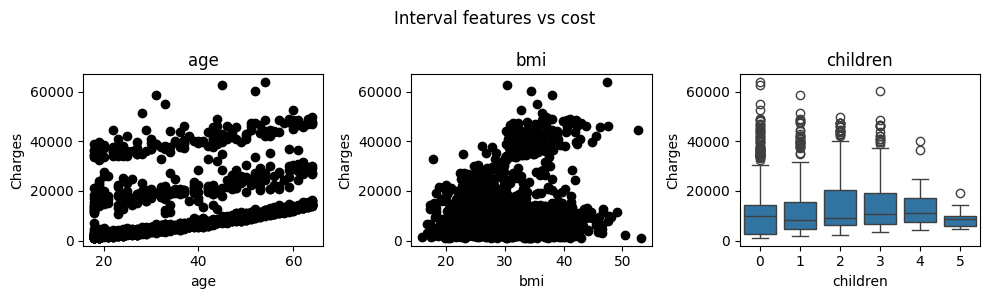

In [47]:
interval_features = ['age', 'bmi', 'children']

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs = axs.flatten()

fig.suptitle('Interval features vs cost')

for i, feature in enumerate(interval_features):

    level_counts = data_df[feature].value_counts()

    if feature != 'children':
        axs[i].set_title(feature)
        axs[i].scatter(data_df[feature], data_df['charges'], color='black')
        axs[i].set_xlabel(feature)
        axs[i].set_ylabel('Charges')

    else:
        sns.boxplot(data=data_df, x=feature, y='charges', ax=axs[i])
        axs[i].set_title(feature)
        axs[i].set_xlabel(feature)
        axs[i].set_ylabel('Charges')

fig.tight_layout()
fig.show()

#### 2.2.2. Nominal features vs label

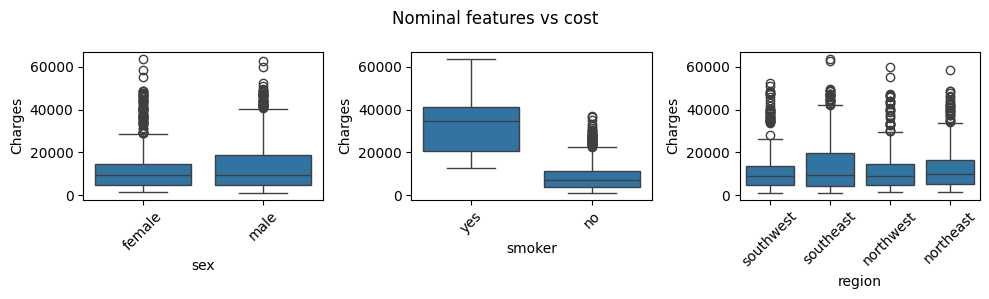

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs = axs.flatten()

fig.suptitle('Nominal features vs cost')

for i, feature in enumerate(nominal_features):

    sns.boxplot(data_df, x=feature, y='charges', ax=axs[i])
    axs[i].tick_params(axis='x', labelrotation=45)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Charges')

plt.tight_layout()
plt.show()

## 3. Data preparation

### 3.1. Train-test split

In [49]:
training_df, testing_df = train_test_split(
    data_df,
    test_size=0.2
)

### 3.2. Feature encoding

In [50]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoder.fit(training_df[nominal_features])

training_df = funcs.encode_features(
    training_df,
    encoder,
    nominal_features
)

testing_df = funcs.encode_features(
    testing_df,
    encoder,
    nominal_features
)

training_df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
1271,25,34.485,0,3021.80915,0.0,0.0,1.0,0.0,0.0
1016,19,24.605,1,2709.24395,0.0,0.0,1.0,0.0,0.0
724,50,27.075,1,10106.13425,0.0,0.0,0.0,0.0,0.0
1157,23,23.180,2,14426.07385,0.0,0.0,1.0,0.0,0.0
1316,19,20.600,0,1731.67700,0.0,0.0,0.0,0.0,1.0


### 3.3. Feature transformation

#### 3.3.1. Power transformer

In [51]:
# feature_transformer = PowerTransformer().fit(training_df[interval_features])
# training_df[interval_features] = feature_transformer.transform(training_df[interval_features])
# testing_df[interval_features] = feature_transformer.transform(testing_df[interval_features])

# label_transformer = PowerTransformer().fit(training_df['charges'].values.reshape(-1, 1))
# training_df['charges'] = label_transformer.transform(training_df['charges'].values.reshape(-1, 1))
# testing_df['charges'] = label_transformer.transform(testing_df['charges'].values.reshape(-1, 1))

# training_df.describe()

In [52]:
# fig, axs = plt.subplots(2,2, figsize=(6,6))
# axs = axs.flatten()

# fig.suptitle('Patient feature distributions')

# for i, feature in enumerate(['age', 'bmi', 'children', 'charges']):
#     axs[i].set_title(feature)
#     axs[i].hist(training_df[feature], color='black', bins=15)
#     axs[i].set_ylabel('Count')

# fig.tight_layout()
# fig.show()

#### 3.3.2. Standard scaling

In [53]:
# features_scaler = StandardScaler().fit(training_df.drop(columns=['charges']))
# training_df[features_scaler.feature_names_in_] = features_scaler.transform(training_df[features_scaler.feature_names_in_])
# testing_df[features_scaler.feature_names_in_] = features_scaler.transform(testing_df[features_scaler.feature_names_in_])

# training_df.describe()

## 4. Model training

In [54]:
results = {}

### 4.1. Baseline

In [55]:
mean_cost = training_df['charges'].mean()
rmse = root_mean_squared_error(testing_df['charges'],[mean_cost]*len(testing_df))

results['Mean cost'] = rmse
print(f'Mean cost model RMSE: ${rmse:.2f}')

Mean cost model RMSE: $12316.72


In [56]:
linear_model = LinearRegression()
linear_model.fit(training_df.drop(columns=['charges']), training_df['charges'])

predictions = linear_model.predict(testing_df.drop(columns=['charges']))
rmse = root_mean_squared_error(testing_df['charges'], predictions)

results['Regression'] = rmse
print(f'Testing data predictions RMSE: ${rmse:.2f}')

Testing data predictions RMSE: $6486.80


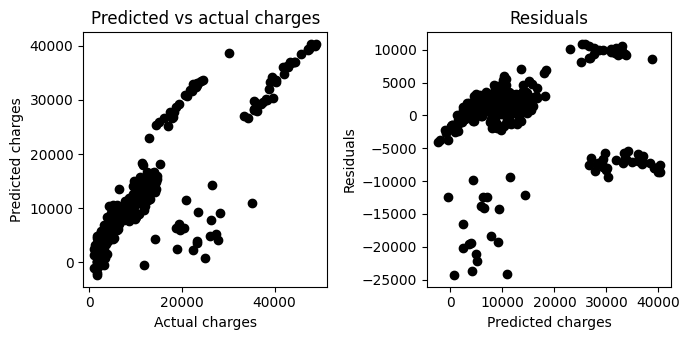

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))
axs = axs.flatten()

axs[0].set_title('Predicted vs actual charges')
axs[0].scatter(testing_df['charges'], predictions, color='black')
axs[0].set_xlabel('Actual charges')
axs[0].set_ylabel('Predicted charges')

axs[1].set_title('Residuals')
axs[1].scatter(predictions, predictions - testing_df['charges'], color='black')
axs[1].set_xlabel('Predicted charges')
axs[1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

## 4. Optimization

### 4.1. Feature transformations

In [58]:
scaled_training_df = training_df.copy()
scaled_testing_df = testing_df.copy()

feature_transformer = StandardScaler().fit(training_df.drop(columns=['charges']))
scaled_training_df[feature_transformer.feature_names_in_] = feature_transformer.transform(training_df[feature_transformer.feature_names_in_])
scaled_testing_df[feature_transformer.feature_names_in_] = feature_transformer.transform(testing_df[feature_transformer.feature_names_in_])

label_transformer = StandardScaler().fit(training_df['charges'].values.reshape(-1, 1))
scaled_training_df['charges'] = label_transformer.transform(training_df['charges'].values.reshape(-1, 1))
scaled_testing_df['charges'] = label_transformer.transform(testing_df['charges'].values.reshape(-1, 1))

training_df.describe()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
count,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000
mean,39.364486,30.638650,1.064486,13163.766638,0.497196,0.202804,0.243925,0.263551,0.242991
std,14.069780,6.142341,1.214409,12058.223046,0.500226,0.402276,0.429649,0.440765,0.429090
min,18.000000,16.815000,0.000000,1135.940700,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,26.237500,0.000000,4718.533675,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.500000,30.275000,1.000000,9223.829500,0.000000,0.000000,0.000000,0.000000,0.000000
75%,51.000000,34.770000,2.000000,16443.294663,1.000000,0.000000,0.000000,1.000000,0.000000
max,64.000000,53.130000,5.000000,63770.428010,1.000000,1.000000,1.000000,1.000000,1.000000


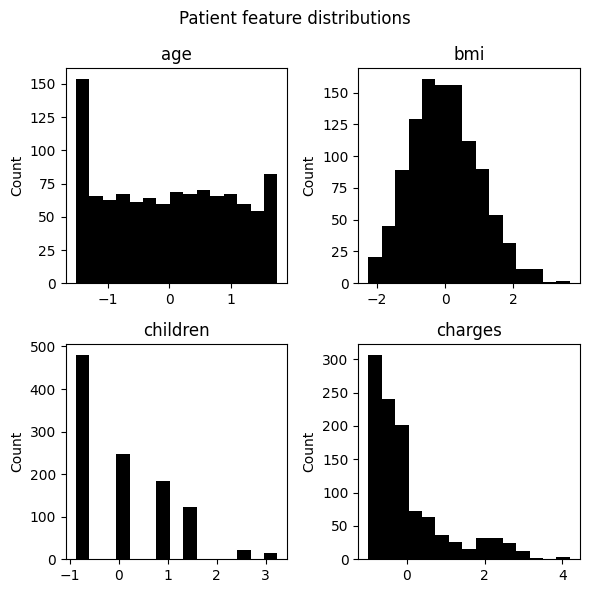

In [59]:
fig, axs = plt.subplots(2,2, figsize=(6,6))
axs = axs.flatten()

fig.suptitle('Patient feature distributions')

for i, feature in enumerate(['age', 'bmi', 'children', 'charges']):
    axs[i].set_title(feature)
    axs[i].hist(scaled_training_df[feature], color='black', bins=15)
    axs[i].set_ylabel('Count')

fig.tight_layout()
fig.show()

In [60]:
linear_model = LinearRegression()
linear_model.fit(scaled_training_df.drop(columns=['charges']), scaled_training_df['charges'])

predictions = linear_model.predict(scaled_testing_df.drop(columns=['charges']))
predictions = label_transformer.inverse_transform(predictions.reshape(-1, 1))
labels = label_transformer.inverse_transform(scaled_testing_df['charges'].values.reshape(-1, 1))
rmse = root_mean_squared_error(labels, predictions)

results['Scaled regression'] = rmse
print(f'Testing data predictions RMSE: ${rmse:.2f}')

Testing data predictions RMSE: $6486.80


### 4.2. Feature engineering

In [61]:
engineered_training_df = training_df.copy()
engineered_testing_df = testing_df.copy()

engineered_training_df['charges'] = engineered_training_df['charges'].clip(upper=50000)
engineered_training_df['age'] = engineered_training_df['age'] ** 2
engineered_training_df['children'] = 1 / (engineered_training_df['children'] + 1)

engineered_testing_df['charges'] = engineered_testing_df['charges'].clip(upper=50000)
engineered_testing_df['age'] = engineered_testing_df['age'] ** 2
engineered_testing_df['children'] = 1 / (engineered_testing_df['children'] + 1)

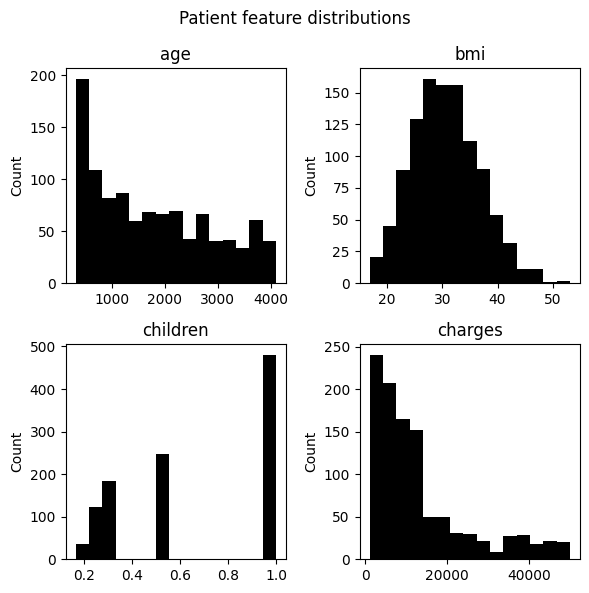

In [62]:
fig, axs = plt.subplots(2,2, figsize=(6,6))
axs = axs.flatten()

fig.suptitle('Patient feature distributions')

for i, feature in enumerate(['age', 'bmi', 'children', 'charges']):
    axs[i].set_title(feature)
    axs[i].hist(engineered_training_df[feature], color='black', bins=15)
    axs[i].set_ylabel('Count')

fig.tight_layout()
fig.show()

In [63]:
linear_model = LinearRegression()
linear_model.fit(engineered_training_df.drop(columns=['charges']), engineered_training_df['charges'])

predictions = linear_model.predict(engineered_testing_df.drop(columns=['charges']))
labels = engineered_testing_df['charges'].values.reshape(-1, 1)
rmse = root_mean_squared_error(labels, predictions)

results['Engineered regression'] = rmse
print(f'Testing data predictions RMSE: ${rmse:.2f}')

Testing data predictions RMSE: $6413.47


### 4.3. Synthetic features

In [66]:
poly_transformer = PolynomialFeatures(degree=4, include_bias=False)
poly_transformer.fit(engineered_training_df.drop(columns=['charges']))
poly_training_features = poly_transformer.transform(engineered_training_df.drop(columns=['charges']))
poly_testing_features = poly_transformer.transform(engineered_testing_df.drop(columns=['charges']))

poly_training_df = pd.DataFrame(poly_training_features, columns=poly_transformer.get_feature_names_out())
poly_testing_df = pd.DataFrame(poly_testing_features, columns=poly_transformer.get_feature_names_out())

poly_training_df['charges'] = engineered_training_df['charges'].values
poly_testing_df['charges'] = engineered_testing_df['charges'].values

poly_training_df.head().transpose()


,0,1,2,3,4
age,625.00000,361.00000,2500.00000,529.000000,361.000
bmi,34.48500,24.60500,27.07500,23.180000,20.600
children,1.00000,0.50000,0.50000,0.333333,1.000
sex_male,0.00000,0.00000,0.00000,0.000000,0.000
smoker_yes,0.00000,0.00000,0.00000,0.000000,0.000
...,...,...,...,...,...
region_southeast^3 region_southwest,0.00000,0.00000,0.00000,0.000000,0.000
region_southeast^2 region_southwest^2,0.00000,0.00000,0.00000,0.000000,0.000
region_southeast region_southwest^3,0.00000,0.00000,0.00000,0.000000,0.000
region_southwest^4,0.00000,0.00000,0.00000,0.000000,1.000


In [67]:
linear_model = LinearRegression()
linear_model.fit(poly_training_df.drop(columns=['charges']), poly_training_df['charges'])

predictions = linear_model.predict(poly_testing_df.drop(columns=['charges']))
labels = poly_testing_df['charges'].values.reshape(-1, 1)
rmse = root_mean_squared_error(labels, predictions)

results['Synthetic features regression'] = rmse
print(f'Testing data predictions RMSE: ${rmse:.2f}')

Testing data predictions RMSE: $5522.27


### 4.4. Results

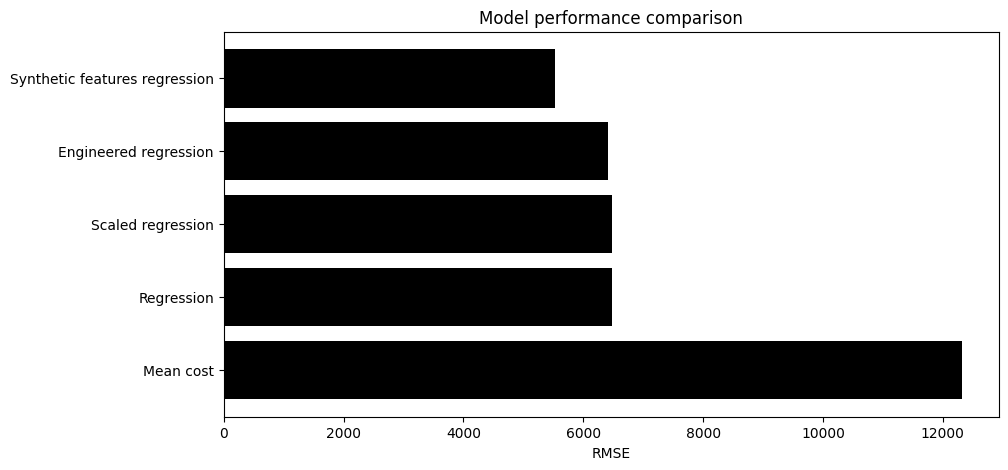

In [68]:
plt.figure(figsize=(10, 5))
plt.barh(list(results.keys()), list(results.values()), color='black')
plt.xlabel('RMSE')
plt.title('Model performance comparison')
plt.show()

## 5. BONUS: split smoker/nonsmoker model

In [ ]:
class SplitModel:
    def __init__(self, training_df, testing_df):
        self.smoker_training_df = training_df[training_df['smoker_yes'] == 1]
        self.nonsmoker_training_df = training_df[training_df['smoker_yes'] == 0]
        self.smoker_training_df.drop('smoker_yes', inplace=True)
        self.nonsmoker_training_df.drop('smoker_yes', inplace=True)

        self.smoker_testing_df = testing_df[testing_df['smoker_yes'] == 1]
        self.nonsmoker_testing_df = testing_df[testing_df['smoker_yes'] == 0]
        self.smoker_testing_df.drop('smoker_yes', inplace=True)
        self.nonsmoker_testing_df.drop('smoker_yes', inplace=True)
        
        self.smoker_model = LinearRegression()
        self.nonsmoker_model = LinearRegression()
        self.smoker_predictions = None
        self.nonsmoker_predictions = None

    def fit(self):
        # Fit the model on the training data

        self.smoker_model.fit(self.smoker_training_df.drop('charges', axis=1), self.smoker_training_df['charges'])
        self.nonsmoker_model.fit(self.nonsmoker_training_df.drop('charges', axis=1), self.nonsmoker_training_df['charges'])

    def predict(self):
        # Make predictions on the testing data

        self.smoker_predictions = self.smoker_model.predict(self.smoker_testing_df.drop('charges', axis=1))
        self.nonsmoker_predictions = self.nonsmoker_model.predict(self.nonsmoker_testing_df.drop('charges', axis=1))

    def evaluate(self):
        # Evaluate the model performance

        predictions = self.smoker_predictions.tolist() + self.nonsmoker_predictions.tolist()
        labels = self.smoker_testing_df['charges'].tolist() + self.nonsmoker_testing_df['charges'].tolist()

        return root_mean_squared_error(labels, predictions)

In [72]:
split_model = SplitModel(poly_training_df, poly_testing_df)
split_model.fit()
split_model.predict()
rmse = split_model.evaluate()

results['Split regression'] = rmse
print(f'Testing data predictions RMSE: ${rmse:.2f}')

Testing data predictions RMSE: $0.00


In [ ]:
plt.scatter(split_model.smoker_predictions, split_model.smoker_testing_df['charges'])

### 4.2. Evaluation

In [ ]:
fig, axs=plt.subplots(1,2, figsize=(8,4))
axs=axs.flatten()

fig.suptitle('Split model evaluation')

axs[0].set_title('True vs predicted charges')
axs[0].scatter(smoker_training_labels, smoker_predictions, color='firebrick', s=5, label='Smokers')
axs[0].scatter(nonsmoker_training_labels, nonsmoker_predictions, color='black', s=5, label='Nonsmokers')
axs[0].tick_params(axis='x', labelrotation=45)
axs[0].set_xlabel('True charges')
axs[0].set_ylabel('Predicted charges')
axs[0].legend(loc='upper left')

axs[1].set_title('Predicted charges vs fit residuals')
axs[1].scatter(smoker_predictions, smoker_training_labels-smoker_predictions, color='firebrick', s=5, label='Smokers')
axs[1].scatter(nonsmoker_predictions, nonsmoker_training_labels-nonsmoker_predictions, color='black', s=5, label='Nonsmokers')
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].set_xlabel('Predicted charges')
axs[1].set_ylabel('True - predicted charges')
axs[1].legend(loc='upper right')

fig.tight_layout()
fig.show()

### 4.3. Data tuning: feature transformations & outlier clipping

In [ ]:
nominal_features=[]
interval_features=['age','bmi','children']

smoker_df=data_df[data_df['smoker'] == 'yes'].copy()
smoker_df.drop('smoker', axis=1, inplace=True)
smoker_df['charges']=smoker_df['charges'].clip(upper=50000)

result=prep_data(smoker_df, nominal_features, interval_features)

smoker_training_features=result[0]
smoker_testing_features=result[1]
smoker_scaled_training_labels=result[2]
smoker_scaled_testing_labels=result[3]
smoker_label_scaler=result[4]

nonsmoker_df=data_df[data_df['smoker'] == 'no'].copy()
nonsmoker_df.drop('smoker', axis=1, inplace=True)
nonsmoker_df['charges']=nonsmoker_df['charges'].clip(upper=50000)
nonsmoker_df['age']=nonsmoker_df['age']**2
nonsmoker_df['children']=1/(nonsmoker_df['children']+1)

result=prep_data(nonsmoker_df, nominal_features, interval_features)

nonsmoker_training_features=result[0]
nonsmoker_testing_features=result[1]
nonsmoker_scaled_training_labels=result[2]
nonsmoker_scaled_testing_labels=result[3]
nonsmoker_label_scaler=result[4]

In [ ]:
smoker_model=LinearRegression()
nonsmoker_model=LinearRegression()

smoker_model.fit(smoker_training_features,smoker_scaled_training_labels)
nonsmoker_model.fit(nonsmoker_training_features,nonsmoker_scaled_training_labels)

smoker_scaled_predictions=smoker_model.predict(smoker_training_features)
nonsmoker_scaled_predictions=nonsmoker_model.predict(nonsmoker_training_features)

smoker_predictions=smoker_label_scaler.inverse_transform(smoker_scaled_predictions)
nonsmoker_predictions=nonsmoker_label_scaler.inverse_transform(nonsmoker_scaled_predictions)

smoker_training_labels=smoker_label_scaler.inverse_transform(smoker_scaled_training_labels)
nonsmoker_training_labels=nonsmoker_label_scaler.inverse_transform(nonsmoker_scaled_training_labels)

predictions=list(smoker_predictions)+list(nonsmoker_predictions)
labels=list(smoker_training_labels)+list(nonsmoker_training_labels)

rmse=root_mean_squared_error(labels, predictions)
print(f'Split model training RMSE: ${rmse:.2f}')

### 4.3. Evaluation

In [ ]:
fig, axs=plt.subplots(1,2, figsize=(8,4))
axs=axs.flatten()

fig.suptitle('Split model evaluation')

axs[0].set_title('True vs predicted charges')
axs[0].scatter(smoker_training_labels, smoker_predictions, color='firebrick', s=5, label='Smokers')
axs[0].scatter(nonsmoker_training_labels, nonsmoker_predictions, color='black', s=5, label='Nonsmokers')
axs[0].tick_params(axis='x', labelrotation=45)
axs[0].set_xlabel('True charges')
axs[0].set_ylabel('Predicted charges')
axs[0].legend(loc='upper left')

axs[1].set_title('Predicted charges vs fit residuals')
axs[1].scatter(smoker_predictions, smoker_training_labels-smoker_predictions, color='firebrick', s=5, label='Smokers')
axs[1].scatter(nonsmoker_predictions, nonsmoker_training_labels-nonsmoker_predictions, color='black', s=5, label='Nonsmokers')
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].set_xlabel('Predicted charges')
axs[1].set_ylabel('True - predicted charges')
axs[1].legend(loc='upper right')

fig.tight_layout()
fig.show()

### 4.4. Final model evaluation

In [ ]:
smoker_scaled_predictions=smoker_model.predict(smoker_testing_features)
nonsmoker_scaled_predictions=nonsmoker_model.predict(nonsmoker_testing_features)

smoker_predictions=smoker_label_scaler.inverse_transform(smoker_scaled_predictions)
nonsmoker_predictions=nonsmoker_label_scaler.inverse_transform(nonsmoker_scaled_predictions)

smoker_testing_labels=smoker_label_scaler.inverse_transform(smoker_scaled_testing_labels)
nonsmoker_testing_labels=nonsmoker_label_scaler.inverse_transform(nonsmoker_scaled_testing_labels)

predictions=list(smoker_predictions)+list(nonsmoker_predictions)
labels=list(smoker_testing_labels)+list(nonsmoker_testing_labels)

rmse=root_mean_squared_error(labels, predictions)
print(f'Split model test RMSE: ${rmse:.2f}')